# import the preprocessed datasets

In [1]:
import pandas as pd
import numpy as np
import glob
from sklearn import linear_model
from sklearn import tree, metrics
from sklearn.metrics import mean_squared_error, accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn

In [2]:
category = {
    1: 'politik', 2: 'wirtschaft', 3: 'finanzen', 4: 'feuilleton', 5: 'sport', 6: 'gesellschaft', 7: 'stil', 
    8: 'technik-motor', 9: 'wissen', 10: 'reise', 11: 'beruf-chance'
}

In [3]:
def train_tables(category):
    raw_train = []
    if category is 'aktuell':
        path = f"../new_data/aktuell/"
    else:
        path = f"../new_data/{category}/"
        
    all_files = glob.glob(path + '*.csv')

    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        raw_train.append(df)
    faz_articles = pd.concat(raw_train, axis=0, ignore_index=True)
    faz_articles['label'] = category

    return faz_articles

def test_tables(category):
    raw_test = []
    if category is 'aktuell':
        path = f"../data/aktuell/"
    else:
        path = f"../data/{category}/"
        
    all_files = glob.glob(path + '*.csv')

    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        raw_test.append(df)
    faz_article = pd.concat(raw_test, axis=0, ignore_index=True)
    faz_article['label'] = category

    return faz_article

---
---
## Load feature list from NaiveBayes approach notebook:

In [4]:
feat = pd.read_csv('/Users/torben/PycharmProjects/toolbox/feature/features.csv', index_col=None, header=0)

feature_list = feat['words'].tolist()

In [5]:
dictionary={}

for i in range(len(feature_list)):
    dictionary[feature_list[i]] = i

---
# Train Data:

In [6]:
frames = []

for key, value in category.items():
    raw_faz = train_tables(value)
    frames.append(raw_faz)
    faz_train = pd.concat(frames, axis=0, ignore_index=True)

In [7]:
faz_train = faz_train.drop_duplicates()

In [8]:
faz_pol = faz_train[faz_train.label == 'politik']
faz_pol_detailed = faz_pol.drop(columns=['link', 'published','title','label'])
faz_pol_titles = faz_pol.drop(columns=['link', 'published','detailed','label'])
faz_pol_titles = faz_pol_titles.rename(index=str, columns={"title": "detailed"})
faz_pol_combined = [faz_pol_detailed,faz_pol_titles]
faz_pol_tot = pd.concat(faz_pol_combined)

faz_sport = faz_train[faz_train.label == 'sport']
faz_sport_detailed = faz_sport.drop(columns=['link', 'published','title','label'])
faz_sport_titles = faz_sport.drop(columns=['link', 'published','detailed','label'])
faz_sport_titles = faz_sport_titles.rename(index=str, columns={"title": "detailed"})
faz_sport_combined = [faz_sport_detailed,faz_sport_titles]
faz_sport_tot = pd.concat(faz_sport_combined)

faz_eco = faz_train[faz_train.label == 'wirtschaft']
faz_eco_detailed = faz_eco.drop(columns=['link', 'published','title','label'])
faz_eco_titles = faz_eco.drop(columns=['link', 'published','detailed','label'])
faz_eco_titles = faz_eco_titles.rename(index=str, columns={"title": "detailed"})
faz_eco_combined = [faz_eco_detailed,faz_eco_titles]
faz_eco_tot = pd.concat(faz_eco_combined)

In [9]:
faz_train_2 = faz_train.copy()

faz_train_2 = faz_train_2[faz_train_2.label != 'politik']
faz_train_2 = faz_train_2[faz_train_2.label != 'sport']
faz_train_2 = faz_train_2[faz_train_2.label != 'wirtschaft']

faz_rem = faz_train_2

In [10]:
faz_rem_detailed = faz_rem.drop(columns=['link', 'published','title','label'])
faz_rem_titles = faz_rem.drop(columns=['link', 'published','detailed','label'])
faz_rem_titles = faz_rem_titles.rename(index=str, columns={"title": "detailed"})
faz_rem_combined = [faz_rem_detailed,faz_rem_titles]
faz_rem_tot = pd.concat(faz_rem_combined)

---
# Iterate over the respective tables of train data:

### Iterate over 'pol' buzzwords:

In [11]:
pol_buzzword = []

for index, row in faz_pol_tot.iterrows():
    new_line = np.zeros(10000)
    words = list(row['detailed'].split(' '))
    for word in words:
        if word in dictionary:
            new_line[dictionary[word]] += 1
    pol_buzzword.append(new_line)
    
    
df_pol = pd.DataFrame(pol_buzzword, columns=feature_list)
df_pol['goal_val'] = 1

### Iterate over 'sport' buzzwords:

In [12]:
sport_buzzword = []

for index, row in faz_sport_tot.iterrows():
    new_line = np.zeros(10000)
    words = list(row['detailed'].split(' '))
    for word in words:
        if word in dictionary:
            new_line[dictionary[word]] += 1
    sport_buzzword.append(new_line)

df_sport = pd.DataFrame(sport_buzzword, columns=feature_list)
df_sport['goal_val'] = 2

### Iterate over 'eco' buzzwords:

In [13]:
eco_buzzword = []

for index, row in faz_eco_tot.iterrows():
    new_line = np.zeros(10000)
    words = list(row['detailed'].split(' '))
    for word in words:
        if word in dictionary:
            new_line[dictionary[word]] += 1
    eco_buzzword.append(new_line)
    
df_eco = pd.DataFrame(eco_buzzword, columns=feature_list)
df_eco['goal_val'] = 3

### Iterate over 'rem' buzzwords:

In [14]:
rem_buzzword = []

for index, row in faz_rem_tot.iterrows():
    new_line = np.zeros(10000)
    words = list(row['detailed'].split(' '))
    for word in words:
        if word in dictionary:
            new_line[dictionary[word]] += 1
    rem_buzzword.append(new_line)
    
df_rem = pd.DataFrame(rem_buzzword, columns=feature_list)
df_rem['goal_val'] = 0

In [15]:
train_tables = [df_pol, df_eco, df_sport, df_rem]
train = pd.concat(train_tables)

---
# Test Data:

In [16]:
frames = []

for key, value in category.items():
    raw_faz = test_tables(value)
    frames.append(raw_faz)
    faz_test = pd.concat(frames, axis=0, ignore_index=True)

In [17]:
faz_test = faz_test.drop_duplicates()

In [18]:
faz_pol_t = faz_test[faz_test.label == 'politik']
faz_sport_t = faz_test[faz_test.label == 'sport']
faz_eco_t = faz_test[faz_test.label == 'wirtschaft']

In [19]:
faz_test_2 = faz_test.copy()

In [20]:
faz_test_2 = faz_test_2[faz_test_2.label != 'politik']
faz_test_2 = faz_test_2[faz_test_2.label != 'sport']
faz_test_2 = faz_test_2[faz_test_2.label != 'wirtschaft']
faz_rem_t = faz_test_2

## pol_t:

In [21]:
pol_buzzword_t = []

for index, row in faz_pol_t.iterrows():
    new_line = np.zeros(10000)
    words = list(row['detailed'].split(' '))
    for word in words:
        if word in dictionary:
            new_line[dictionary[word]] += 1
    pol_buzzword_t.append(new_line)
    
df_pol_t = pd.DataFrame(pol_buzzword_t, columns=feature_list)
df_pol_t['goal_val'] = 1

## sport_t:

In [22]:
sport_buzzword_t = []

for index, row in faz_sport_t.iterrows():
    new_line = np.zeros(10000)
    words = list(row['detailed'].split(' '))
    for word in words:
        if word in dictionary:
            new_line[dictionary[word]] += 1
    sport_buzzword_t.append(new_line)
    
df_sport_t = pd.DataFrame(sport_buzzword_t, columns=feature_list)
df_sport_t['goal_val'] = 2

## eco_t:

In [23]:
eco_buzzword_t = []

for index, row in faz_eco_t.iterrows():
    new_line = np.zeros(10000)
    words = list(row['detailed'].split(' '))
    for word in words:
        if word in dictionary:
            new_line[dictionary[word]] += 1
    eco_buzzword_t.append(new_line)
    
df_eco_t = pd.DataFrame(eco_buzzword_t, columns=feature_list)
df_eco_t['goal_val'] = 3

## rem_t:

In [24]:
rem_buzzword_t = []

for index, row in faz_rem_t.iterrows():
    new_line = np.zeros(10000)
    words = list(row['detailed'].split(' '))
    for word in words:
        if word in dictionary:
            new_line[dictionary[word]] += 1
    rem_buzzword_t.append(new_line)
    
df_rem_t = pd.DataFrame(rem_buzzword_t, columns=feature_list)
df_rem_t['goal_val'] = 0

In [25]:
test_tables = [df_pol_t, df_sport_t, df_eco_t, df_rem_t]
test = pd.concat(test_tables)

--- 
## prepare data for NN:

In [26]:
y_train = train['goal_val'].values
y_test = test['goal_val'].values
X_train = train.drop(['goal_val'], axis=1).values
X_test = test.drop(['goal_val'], axis=1).values

In [27]:
hot_X_train = X_train.copy()
hot_X_train[hot_X_train > 0] = 1

hot_X_test = X_test.copy()
hot_X_test[hot_X_test > 0] = 1

In [28]:
X_train = hot_X_train
X_test =  hot_X_test

## assign data to variables

In [29]:
X_val, X_train, y_val, y_train = train_test_split(X_train, y_train, test_size=0.7)

In [30]:
dtype = torch.float
device = torch.device("cpu")

In [31]:
x_torch_train = torch.tensor(X_train, device=device, dtype=dtype)

y_torch_train = torch.tensor(y_train, device=device, dtype=torch.long)

x_torch_val = torch.tensor(X_val, device=device, dtype=dtype)

y_torch_val = torch.tensor(y_val, device=device, dtype=torch.long)

In [32]:
x_torch_train.shape

torch.Size([2149, 10000])

In [33]:
y_torch_train.shape

torch.Size([2149])

---

In [48]:
# N sind die Anzahl der Datenpunkte 
# D_in ist die Input-Dimension
# D_out ist die Output-Dimension
D_in, N_classes = 10000, 50
H = 1024
H2 = 512
H3 = 128

In [49]:
### 2-Layer-Network
model = torch.nn.Sequential(   
    nn.Linear(D_in, H),
    nn.ReLU(),
    nn.Linear(H, H2),
    nn.ReLU(),
    nn.Linear(H2, H3),
    nn.ReLU(),
    nn.Linear(H3, N_classes)
)

In [50]:
learning_rate = 0.001
weight_decay = 0.01

In [51]:
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay)

In [52]:
loss_hist = []
val_loss_hist = []

In [53]:
# Train
for t in range(1000):
    # Berechne die Vorhersage (foward step)
    outputs = model(x_torch_train)
    val_outputs = model(x_torch_val) 
    # Berechne den Fehler (Ausgabe des Fehlers alle 100 Iterationen)
    loss = criterion(outputs, y_torch_train)
    val_loss = criterion(val_outputs, y_torch_val)
    # Berechne die Gradienten und Aktualisiere die Gewichte (backward step)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Berechne den Fehler (Ausgabe des Fehlers alle 100 Iterationen)
    #if t % 1000 == 0:
    loss_hist.append(loss.item())
    val_loss_hist.append(val_loss.item())
    #    print(t, loss.item())

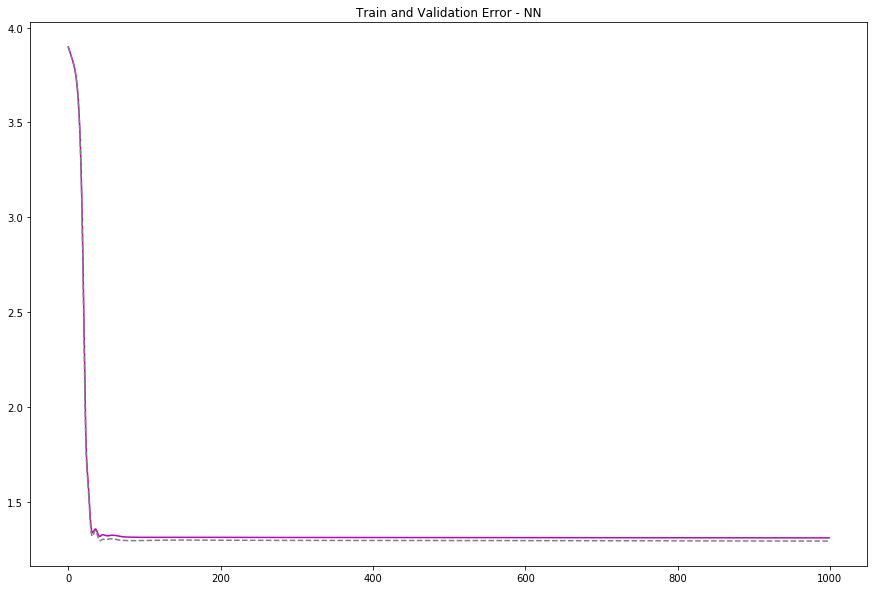

In [54]:
plt.figure(1, figsize=(15,10))
plt.plot(val_loss_hist, color='m', lw=1.5)
plt.plot(loss_hist, color='grey', lw=1.5, linestyle='--')
plt.title('Train and Validation Error - NN')
plt.show();

In [55]:
torch.max(model(x_torch_train), 1)

(tensor([7.6810, 7.8173, 7.7252,  ..., 7.0141, 7.8920, 7.6810],
        grad_fn=<MaxBackward0>), tensor([0, 0, 0,  ..., 0, 0, 0]))

---

In [56]:
x_torch_test = torch.tensor(X_test, device=device, dtype=dtype)

y_torch_test = torch.tensor(y_test,device=device, dtype=torch.long)

In [57]:
softmax = torch.nn.Softmax()

y_test_pred = softmax(model(x_torch_test)).argmax(1)
y_train_pred = softmax(model(x_torch_train)).argmax(1)

/anaconda3/envs/toolbox/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/envs/toolbox/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


In [58]:
train_accuracy = accuracy_score(y_torch_train, y_train_pred)
test_accuracy = accuracy_score(y_torch_test, y_test_pred)

In [59]:
print(f'The TRAIN prediction is {train_accuracy*100} % ACCURATE')
print(f'The TEST prediction is {test_accuracy*100} % ACCURATE')

The TRAIN prediction is 43.46207538389949 % ACCURATE
The TEST prediction is 51.332149200710475 % ACCURATE


---